## Herschel-ATLAS Data Release III - Identifications

*** Description of the notebook ***

### Imports

In [1]:
# Dependencies
import utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from lmfit import Model, fit_report
utils.rcparams()

In [2]:
# Loading the datasets
background = utils.full_loader('Background_15')
data = utils.full_loader('Data_15')

C:\Users\bradl\AppData\Local\Temp/ipykernel_7876/896354622.py:2: DtypeWarning: Columns (21,26,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  background = utils.full_loader('Background_15')
C:\Users\bradl\AppData\Local\Temp/ipykernel_7876/896354622.py:3: DtypeWarning: Columns (48,53,56,57) have mixed types.Specify dtype option on import or set low_memory=False.
  data = utils.full_loader('Data_15')


### Star-Galaxy Classifier

In this section we use an altered version of the Baldry et al, 2010 method to classify stars and galaxies.
Our classification systems uses the following key:

    0 - Star based on stellar probability > 0.95
    1 - Galaxy based on J-K/g-i colour-colour plot
    2 - Star based on J-K/g-i colour-colour plot
    3 - Galaxy based on J-K > something
    4 - Star based on J-K < something
    5 - Star based on stellar probability > 0.7
    6 - Galaxy based on all other

In [3]:
# Adding a column for star-galaxy classification of background and data objects
background['SG_key'] = utils.classification(background, 'JAPERMAG3', 'KSAPERMAG3', 'COLOUR_GAAP_g_r', 'COLOUR_GAAP_r_i', 'PSTAR')
data['SG_key'] = utils.classification(data, 'JAPERMAG3', 'KSAPERMAG3', 'COLOUR_GAAP_g_r', 'COLOUR_GAAP_r_i', 'PSTAR')

# A simplified key for just star/galaxy flag
background['SG'] = [1 if (flag == 1) | (flag == 3) | (flag == 6) else 0 for flag in background['SG_key']]
data['SG'] = [1 if (flag == 1) | (flag == 3) | (flag == 6) else 0 for flag in data['SG_key']]

Star-Galaxy Classification: 100%|██████████| 1008098/1008098 [00:12<00:00, 81560.06it/s]


In [4]:
# Print outs of the number of objects classified in different ways
galaxy = [flag for flag in data['SG'] if flag == 1]
star = [flag for flag in data['SG'] if flag == 0]
star_p95 = [flag for flag in data['SG_key'] if (flag == 0)]
galaxy_KiDS = [flag for flag in data['SG_key'] if (flag == 1)]
star_KiDS = [flag for flag in data['SG_key'] if (flag == 2)]
galaxy_JK = [flag for flag in data['SG_key'] if (flag == 3)]
star_JK = [flag for flag in data['SG_key'] if (flag == 4)]
star_p70 = [flag for flag in data['SG_key'] if (flag == 5)]
galaxy_other = [flag for flag in data['SG_key'] if (flag == 6)]

print("Number of galaxies = {:.0f}".format(len(galaxy)))
print("Number of stars = {:.0f}".format(len(star)))
print("Number of stars with p(>0.95) = {:.0f}".format(len(star_p95)))
print("Number of galaxies from KiDS colour-colour = {:.0f}".format(len(galaxy_KiDS)))
print("Number of stars from KiDS colour-colour = {:.0f}".format(len(star_KiDS)))
print("Number of galaxies from J-K > constant = {:.0f}".format(len(galaxy_JK)))
print("Number of stars from J-K < constant = {:.0f}".format(len(star_JK)))
print("Number of stars with p(>0.70) = {:.0f}".format(len(star_p70)))
print("Number of galaxies (other) = {:.0f}".format(len(galaxy_other)))

print("The constant defining J-K > constant = {:.4f}".format(utils.stellar_locus(1000, 0.2)))
print("The constant defining J-K < constant = {:.4f}".format(utils.stellar_locus(0, 0.2)))

Number of galaxies = 841469
Number of stars = 166629
Number of stars with p(>0.95) = 51508
Number of galaxies from KiDS colour-colour = 299519
Number of stars from KiDS colour-colour = 111966
Number of galaxies from J-K > constant = 102276
Number of stars from J-K < constant = 280
Number of stars with p(>0.70) = 2875
Number of galaxies (other) = 439674
The constant defining J-K > constant = 0.9768
The constant defining J-K < constant = 0.4228


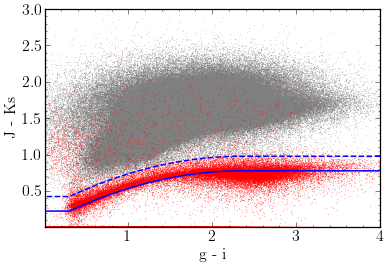

In [5]:
# Plot of the star-galaxy classification
gi_range = np.linspace(-3, 5, 1000)
jk_rangelocus = [utils.stellar_locus(i, 0) for i in gi_range]
jk_rangecut = [utils.stellar_locus(i, 0.2) for i in gi_range]

# Separation of stars and galaxies for the plot
galaxies = data[data['SG'] == 1]
stars = data[data['SG'] == 0]

# Separation of stars and galaxies in background for future reference
galaxies_back = background[background['SG'] == 1]
stars_back = background[background['SG'] == 0]

plt.figure()
plt.scatter(galaxies['COLOUR_GAAP_g_r'] + galaxies['COLOUR_GAAP_r_i'], galaxies['JAPERMAG3'] - galaxies['KSAPERMAG3'], s = 0.01, color = 'gray', rasterized = True)
plt.scatter(stars['COLOUR_GAAP_g_r'] + stars['COLOUR_GAAP_r_i'], stars['JAPERMAG3'] - stars['KSAPERMAG3'], s = 0.01, color = 'r', rasterized = True)
plt.plot(gi_range, jk_rangelocus, linestyle = '-', linewidth = 1.5, color = 'b')
plt.plot(gi_range, jk_rangecut, linestyle = '--', linewidth = 1.5, color = 'b')
plt.xlabel('g - i')
plt.ylabel('J - Ks')
plt.xlim(0.01, 4)
plt.ylim(0.01, 3)
plt.show()

### Determining Constants

Determining the value of Q and $\sigma_{\textrm{pos}}$. We determine the value of Q by counting the number of blank sources we observe in the datafile and in the background.
This split into all possible candidates and extragalactic candidates. Note that we sum up three components (0, 1 and multi);
this represents whether there is a blank because no object is found (0), there is a blank but with 1 object outside the current search radius (1) or multiple objects all of which are outside the current search radius (multi).

#### Determining $Q_0$

In [6]:
# Defining a range of r values to compute the blanks over
r_range = np.linspace(0, 14, 15)
data_blanks = []
data_blanks_gal = []
background_blanks = []
background_blanks_gal = []

# Computing the number of blank positions in the data and background (plus considering only extragalactic sources)
for r in tqdm(r_range, desc = 'Blank testing'):

    # Calculating blanks
    data_blanks_r = utils.blanks(data, r, 'GroupID', 'DISTANCE')
    data_blanks_gal_r = utils.blanks(galaxies, r, 'GroupID', 'DISTANCE')
    background_blanks_r = utils.blanks(background, r, 'GroupID', 'DISTANCE')
    background_blanks_gal_r = utils.blanks(galaxies_back, r, 'GroupID', 'DISTANCE')

    # Appending the blanks to lists
    data_blanks.append(data_blanks_r/193527)
    data_blanks_gal.append(data_blanks_gal_r/193527)
    background_blanks.append(background_blanks_r/844715)
    background_blanks_gal.append(background_blanks_gal_r/844715)

# Calculate our estimate of 1-Q0 by dividing data blanks by background blanks
blanks = [data/background for data, background in zip(data_blanks, background_blanks)]
blanks_gals = [data/background for data, background in zip(data_blanks_gal, background_blanks_gal)]

Blank testing: 100%|██████████| 15/15 [03:58<00:00, 15.89s/it]


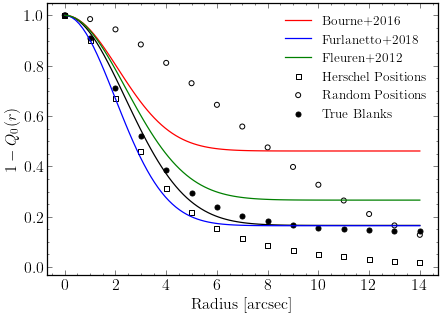

Best fitting value of Q0 (All) = 0.835 +- 0.009
Best fitting value of Q0 (Galaxies) = 0.827 +- 0.013
Best fitting value of sigma(pos) = 2.388 +- 0.065


In [57]:
# Create a model for our 1-Q0 distribution
bmodel = Model(utils.B)
params = bmodel.make_params(sigma = 2, Q0 = 0.8)

# Define model parameters and fit the model
params['sigma'].vary = True
params['Q0'].vary = True
fit_result = bmodel.fit(blanks, params, r = r_range)
fit_result_gals = bmodel.fit(blanks_gals, params, r = r_range)

# Determine the best fitting values of parameters
sigma_pos, sigma_pos_err = fit_result.params['sigma'].value, fit_result.params['sigma'].stderr
q0, q0_err = fit_result.params['Q0'].value, fit_result.params['Q0'].stderr
q0_gals, q0_gals_err = fit_result_gals.params['Q0'].value, fit_result_gals.params['Q0'].stderr
q0_stars = q0 - q0_gals

# Plot of the best fitting values and literature estimates
plot_rrange = np.linspace(0, 14, 100)
plt.figure(figsize = (7, 5))
plt.scatter(r_range, data_blanks, marker = 's', s = 25, facecolor= 'none', color = 'k', label = 'Herschel Positions')
plt.scatter(r_range, background_blanks, marker = 'o', s = 25, facecolor= 'none', color ='k', label = 'Random Positions')
plt.scatter(r_range, blanks, s = 25, color = 'k', label = 'True Blanks')
plt.plot(plot_rrange, utils.B(plot_rrange, sigma_pos, q0))
plt.plot(plot_rrange, utils.B(plot_rrange, 2.10, 0.5390), color = 'r', label = r'Bourne+2016')
plt.plot(plot_rrange, utils.B(plot_rrange, 1.99, 0.8360), color = 'b', label = r'Furlanetto+2018')
plt.plot(plot_rrange, utils.B(plot_rrange, 2.40, 0.7342), color = 'g',  label = r'Fleuren+2012')
plt.xlabel(r'Radius [arcsec]')
plt.ylabel(r'$1 - Q_0(r)$')
plt.legend()
plt.show()

print(r'Best fitting value of Q0 (All) = {:.3f} +- {:.3f}'.format(q0, q0_err))
print(r'Best fitting value of Q0 (Galaxies) = {:.3f} +- {:.3f}'.format(q0_gals, q0_gals_err))
print(r'Best fitting value of sigma(pos) = {:.3f} +- {:.3f}'.format(sigma_pos, sigma_pos_err))


#### Determining k

In [37]:
# Gather just unique rows in data, so we are calculating k over just the sources
unique_sources = data.drop_duplicates(subset = 'IDNAME')
unique_sources = unique_sources.reset_index()

# Computing the median k value
FWHM = 18.1
k_values = utils.K(unique_sources, FWHM, sigma_pos, 'F250BEST', 'E250BEST')
k_const = np.nanmedian(k_values)
print('Best fitting value of k = {:.3f}'.format(k_const))


100%|██████████| 193527/193527 [00:01<00:00, 168416.21it/s]

Best fitting value of k = 0.663


### Likelihood Ratio Method

*** Some description to go here ***

#### K-band Distributions

C:\Users\bradl\Desktop\HerschelATLASDR3_2\utils\likelihood_ratio.py:40: RuntimeWarning: invalid value encountered in true_divide
  q_over_n = q / n_normalized
C:\Users\bradl\Desktop\HerschelATLASDR3_2\utils\likelihood_ratio.py:40: RuntimeWarning: divide by zero encountered in true_divide
  q_over_n = q / n_normalized


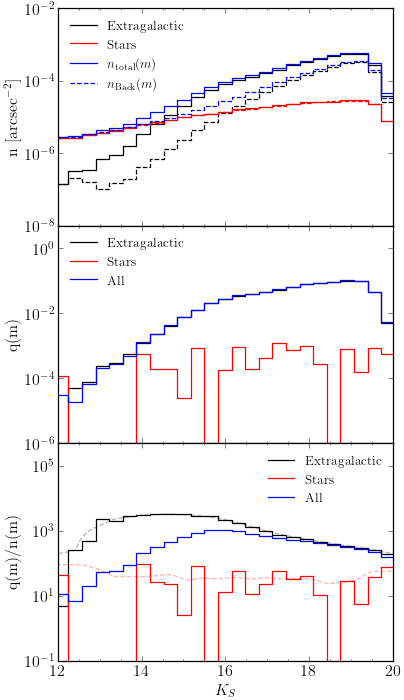

In [70]:
# Generate the n distributions
bin_centres, n_real, n_data_normalized, n_back_normalized = utils.N(data, background, Ndata = 193527, Nback = 844715, r = 15, band = 'KSAPERMAG3')
_, n_real_gals, n_data_normalized_gals, n_back_normalized_gals = utils.N(galaxies, galaxies_back, Ndata = 193527, Nback = 844715, r = 15, band = 'KSAPERMAG3')
_, n_real_stars, n_data_normalized_stars, n_back_normalized_stars = utils.N(stars, stars_back, Ndata = 193527, Nback = 844715, r = 15, band = 'KSAPERMAG3')

# Generate the q/n distributions
mag_range, q, qn, interp_qn = utils.q_div_n(n_real, n_back_normalized, q0, bin_centres, window_size = 3)
_, q_gals, qn_gals, interp_qn_gals = utils.q_div_n(n_real_gals, n_back_normalized_gals, q0_gals, bin_centres, window_size = 3)
_, q_stars, qn_stars, interp_qn_stars = utils.q_div_n(n_real_stars, n_back_normalized_stars, q0_stars, bin_centres, window_size = 5)


# Plot of the n, q and q/n distributions for the data and background for both stars, galaxies and all objects
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True, sharey=False, figsize = (6, 12))
fig.subplots_adjust(hspace = 0)

ax1.step(bin_centres, n_data_normalized_gals, where = 'mid', color = 'k', label =  r'Extragalactic')
ax1.step(bin_centres, n_back_normalized_gals, where = 'mid', color = 'k', linestyle = '--')
ax1.step(bin_centres, n_data_normalized_stars, where = 'mid', color = 'r', label =  r'Stars')
ax1.step(bin_centres, n_back_normalized_stars,  where = 'mid', color = 'r', linestyle = '--')
ax1.step(bin_centres, n_data_normalized, where = 'mid', color = 'b', label = r'$n_{\mathrm{total}}(m)$')
ax1.step(bin_centres, n_back_normalized, where = 'mid', color = 'b', linestyle = '--', label =  r'$n_{\mathrm{Back}}(m)$')
ax1.set_ylabel(r'n [arcsec$^{-2}$]')
ax1.legend()
ax1.set_ylim(1e-8, 1e-2)
ax1.semilogy()

ax2.step(bin_centres, q_gals, where = 'mid', color = 'k', label = 'Extragalactic')
ax2.step(bin_centres, q_stars, where = 'mid', color = 'r', label = 'Stars')
ax2.step(bin_centres, q, where = 'mid', color = 'b', label = 'All')
ax2.set_ylabel(r'q(m)')
ax2.legend()
ax2.set_ylim(1e-6, 5e0)
ax2.semilogy()

ax3.plot(mag_range, interp_qn_gals, color = 'k', alpha = 0.3, linestyle = '--')
ax3.plot(mag_range, interp_qn_stars, color = 'r', alpha = 0.3, linestyle = '--')
ax3.step(bin_centres, qn_gals, where = 'mid', color = 'k', label = 'Extragalactic')
ax3.step(bin_centres, qn_stars,  where = 'mid', color = 'r', label = 'Stars')
ax3.step(bin_centres, qn, where = 'mid', color = 'b', label = 'All')
ax3.set_xlabel(r'$K_S$')
ax3.set_ylabel(r'q(m)/n(m)')
ax3.legend()
ax3.set_xlim(12, 20)
ax3.set_ylim(1e-1, 5e5)
ax3.semilogy()

plt.show()

#### Likelihood Values

In [94]:
# Generate tuples for q/n distributions and calculate LR values
qn_gal_tuple = (mag_range, interp_qn_gals)
qn_stars_tuple = (mag_range, interp_qn_stars)
likelihoods = utils.likelihood(data, 'IAUNAME', 'F250BEST', 'E250BEST', 'SG', 'DISTANCE', 'KSAPERMAG3', k_const, FWHM, qn_gal_tuple, qn_stars_tuple)

# Assign a new column to the data
data['likelihood'] = likelihoods

Likelihood Ratio calculations: 100%|██████████| 1008098/1008098 [00:43<00:00, 23399.61it/s]


#### Reliability Values

In [97]:
# Calculate the reliability values and assign a new column to the data
reliabilities = utils.reliability(data, 'IAUNAME', 'GroupID', 'likelihood', q0)
data['reliability'] = reliabilities

Reliability calculations: 100%|██████████| 1008098/1008098 [00:12<00:00, 83643.47it/s]


In [ ]:
import importlib
import sys

_ = importlib.reload(sys.modules['utils'])